In [1]:
import os
os.environ["UNSLOTH_VLLM_STANDBY"] = "0"
if "COLAB_" not in "".join(os.environ.keys()):
    %pip install unsloth vllm -q
else:
    pass 


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os

if "COLAB_" not in "".join(os.environ.keys()):
    %pip install unsloth vllm -q
else:
    try: import numpy; get_numpy = f"numpy=={numpy.__version__}"
    except: get_numpy = "numpy"
    try: import subprocess; is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
    except: is_t4 = False
    get_vllm = "vllm==0.9.2" if is_t4 else "vllm==0.10.2"
    %pip install {get_vllm} {get_numpy} torchvision bitsandbytes xformers -q
    %pip install triton -q

%pip install transformers==4.56.1 trl==0.23.0 -q 


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
# Unsloth - Load Qwen2.5-VL-32B model
from unsloth import FastVisionModel
import torch

max_seq_length = 16384

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "/home/jupyter/datasphere/project/qwen2.5-vl-32b-qlora-a100-copy",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # for QLoRA
    fast_inference = False, # Enable vLLM fast inference
    gpu_memory_utilization = 0.7,  # Reduced for 32B model
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-10-15 17:49:16.993805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 17:49:20.286375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO 10-15 17:50:07 [__init__.py:216] Automatically detected platform cuda.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.1: Fast Qwen2_5_Vl patching. Transformers: 4.56.1. vLLM: 0.11.0.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.325 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 4/4 [03:44<00:00, 56.05s/it]


In [4]:
model.fast_inference = True
os.environ["UNSLOTH_VLLM_STANDBY"] = "1"

In [5]:
print("Model quantization:")
print(f"Model dtype: {model.dtype}")
print(f"Model device: {model.device}")

# Check params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable %: {trainable_params/total_params*100:.2f}%")

# If trainable % is very low (~0.1-1%) - it is QLoRA

Model quantization:
Model dtype: torch.bfloat16
Model device: cuda:0
Total parameters: 17,678,137,600
Trainable parameters: 145,424,384
Trainable %: 0.82%


In [6]:
# Check if LoRA adapters are loaded
if hasattr(model, 'peft_config') and model.peft_config:
    print("LoRA adapters are active:")
    for adapter_name, config in model.peft_config.items():
        print(f"  - {adapter_name}: r={config.r}, alpha={config.lora_alpha}")
else:
    print("Adapters not found - something went wrong")

LoRA adapters are active:
  - default: r=16, alpha=16


In [7]:
# Load datasets
from datasets import load_dataset, Features, Sequence, Value, Image as HFImage
from IPython.display import display

# Dataset path
dataset_path = "/home/jupyter/datasphere/project/docvqa-ru-eng-v1"

# Define features schema
features = Features({
    'image': HFImage(decode=True), 
    'question': Value('string'),
    'answer': Value('string'),
    'source': Value('string')
})

# Load dataset
dataset = load_dataset(dataset_path, features=features)

print("Dataset loaded successfully")
print(dataset) 

Dataset loaded successfully
DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer', 'source'],
        num_rows: 17008
    })
    validation: Dataset({
        features: ['image', 'question', 'answer', 'source'],
        num_rows: 3647
    })
    test: Dataset({
        features: ['image', 'question', 'answer', 'source'],
        num_rows: 3647
    })
})



First training example:
Source: None
Question: Q4:
Answer: From the document, it can be inferred that working in a busy post office can be challenging and physically and mentally exhausting, but positive attitudes and bucket filling can help overcome these difficulties.
Image field type: <class 'PIL.PngImagePlugin.PngImageFile'>
Image type: <class 'PIL.PngImagePlugin.PngImageFile'>
Image size: (1275, 1650)

First image:


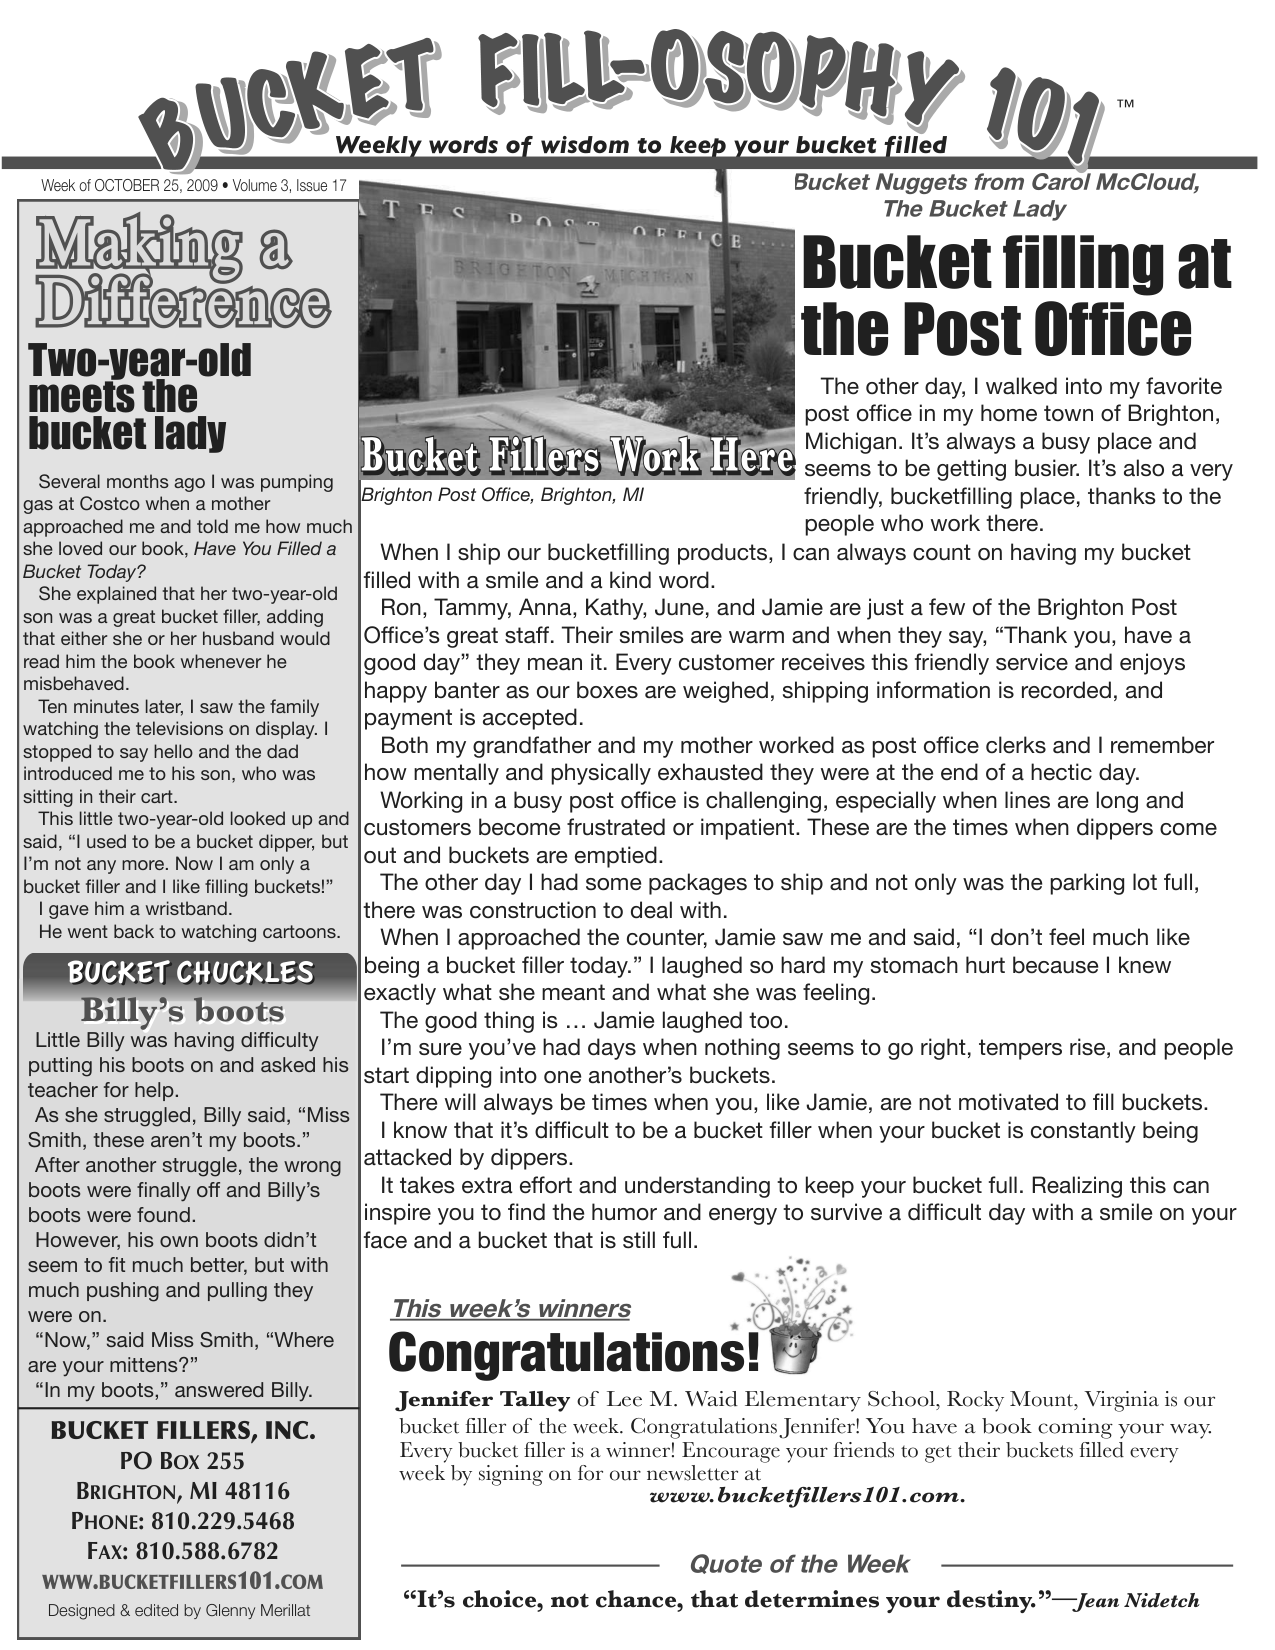

In [37]:
# Define the splits properly
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

# Inspect first training example
print("\nFirst training example:")
example = train_dataset[0]

print(f"Source: {example['source']}")
print(f"Question: {example['question']}")
print(f"Answer: {example['answer']}")  
print(f"Image field type: {type(example['image'])}")  
print(f"Image type: {type(example['image'])}")
print(f"Image size: {example['image'].size}")

# Display first image
print("\nFirst image:")
display(example['image']) 

In [38]:
from PIL import Image
import io

print("Starting image resizing to prevent training errors...")
MAX_IMAGE_SIZE = (1536, 1536)

def resize_image(example):
    image = example['image'].convert("RGB")
    
    image.thumbnail(MAX_IMAGE_SIZE, Image.Resampling.LANCZOS)
    
    example['image'] = image
    return example

print("\nResizing train dataset images...")
train_dataset = train_dataset.map(resize_image, num_proc=4)

print("Resizing validation dataset images...")
val_dataset = val_dataset.map(resize_image, num_proc=4)

print("Resizing test dataset images...")
test_dataset = test_dataset.map(resize_image, num_proc=4)

print("\nImage resizing complete for all datasets!")
print("Now all images are guaranteed to be within a reasonable size.")

print("\nSize of the first training image after resizing:")
print(train_dataset[0]['image'].size)

Starting image resizing to prevent training errors...

Resizing train dataset images...




Map (num_proc=4):   0%|          | 0/17008 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 1/17008 [00:00<2:30:41,  1.88 examples/s]

Map (num_proc=4):   0%|          | 10/17008 [00:00<14:23, 19.68 examples/s] 

Map (num_proc=4):   0%|          | 32/17008 [00:00<04:39, 60.74 examples/s]

Map (num_proc=4):   0%|          | 48/17008 [00:00<03:45, 75.12 examples/s]

Map (num_proc=4):   0%|          | 71/17008 [00:01<02:39, 105.96 examples/s]

Map (num_proc=4):   1%|          | 93/17008 [00:01<02:14, 125.45 examples/s]

Map (num_proc=4):   1%|          | 116/17008 [00:01<01:57, 143.46 examples/s]

Map (num_proc=4):   1%|          | 133/17008 [00:01<01:59, 141.52 examples/s]

Map (num_proc=4):   1%|          | 150/17008 [00:01<01:54, 146.80 examples/s]

Map (num_proc=4):   1%|          | 175/17008 [00:01<01:53, 148.22 examples/s]

Map (num_proc=4):   1%|          | 197/17008 [00:01<01:42, 163.44 examples/s]

Map (num_proc=4):   1%|▏         | 217/17008 [00:01<01:52, 149.20 exa

Resizing validation dataset images...



Map (num_proc=4): 100%|██████████| 3647/3647 [04:09<00:00, 14.62 examples/s]


Resizing test dataset images...



Map (num_proc=4): 100%|██████████| 3647/3647 [04:14<00:00, 14.34 examples/s]


Image resizing complete for all datasets!
Now all images are guaranteed to be within a reasonable size.

Size of the first training image after resizing:
(1187, 1536)


In [ ]:
# Explore dataset structure
print(f"Loaded - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"\nFeatures: {train_dataset.column_names}")

In [40]:
# Define the delimiter variables for clarity and easy modification
REASONING_START = "<REASONING>"
REASONING_END = "</REASONING>"
SOLUTION_START = "<SOLUTION>"
SOLUTION_END = "</SOLUTION>"

def make_conversation(example):
    instruction = (
        "Analyze the document image and answer the question. "
        "The document may contain text in Russian or English. "
        "Provide your answer in the same language as the question."
    )
    
    text_content = (
        f"{instruction}\n\nQuestion: {example['question']}\n\n"
        f"First provide your analysis of the document between {REASONING_START} and {REASONING_END} "
        f"and then your final answer between {SOLUTION_START} and {SOLUTION_END}"
    )

    prompt = [
        {
            "role": "user",
            "content": [
                {"type": "image"},  # Placeholder for the image
                {"type": "text", "text": text_content},  # The text part of the prompt
            ],
        },
    ]
    
    return {
        "prompt": prompt, 
        "image": example["image"], 
        "answer": example["answer"] 
    }

In [41]:
print("Converting to GRPO format...")

print("Converting train dataset...")
train_converted = train_dataset.map(
    make_conversation,
    batched=False,
    remove_columns=train_dataset.column_names,
    num_proc=4
)

print(f"GRPO converted - Train: {len(train_converted)}")

Converting to GRPO format...
Converting train dataset...



Map (num_proc=4): 100%|██████████| 17008/17008 [16:42<00:00, 16.97 examples/s]

GRPO converted - Train: 17008


In [42]:
sample = train_converted[0]
print(f"Keys: {list(sample.keys())}") 
print(f"Answer: {sample['answer']}") 


actual_image = sample['image'] 
print(f"Image type in sample: {type(actual_image)}")
print(f"Image size: {actual_image.size}")


print("\nPrompt structure preview:")
for i, content in enumerate(sample['prompt'][0]['content']):
    if content['type'] == 'text':
        print(f"Text content: {content['text'][:100]}...")

Keys: ['image', 'answer', 'prompt']
Answer: From the document, it can be inferred that working in a busy post office can be challenging and physically and mentally exhausting, but positive attitudes and bucket filling can help overcome these difficulties.
Image type in sample: <class 'PIL.PngImagePlugin.PngImageFile'>
Image size: (1187, 1536)

Prompt structure preview:
Text content: Analyze the document image and answer the question. The document may contain text in Russian or Engl...


In [43]:
train_converted = train_converted.map(
    lambda example: {
        "prompt": tokenizer.apply_chat_template(
            example["prompt"],
            tokenize=False,
            add_generation_prompt=True,
        ),
        "image": example["image"],
        "answer": example["answer"] 
    }
)


Map: 100%|██████████| 17008/17008 [56:49<00:00,  4.99 examples/s]


In [44]:
print("\nAfter chat template:")
sample = train_converted[0]
print(f"Keys: {list(sample.keys())}")
print(f"Prompt type: {type(sample['prompt'])}") 
print(f"Prompt preview: {sample['prompt'][:200]}...")
print(f"Image type: {type(sample['image'])}") 
print(f"Answer: {sample['answer']}")


After chat template:
Keys: ['image', 'answer', 'prompt']
Prompt type: <class 'str'>
Prompt preview: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Analyze the document image and answer the question. The document may contain text ...
Image type: <class 'PIL.PngImagePlugin.PngImageFile'>
Answer: From the document, it can be inferred that working in a busy post office can be challenging and physically and mentally exhausting, but positive attitudes and bucket filling can help overcome these difficulties.


In [45]:
# Reward functions for GRPO training
import re

def formatting_reward_func(completions, **kwargs):
    """Reward function for proper formatting"""
    
    thinking_pattern = f'{REASONING_START}(.*?){REASONING_END}'
    answer_pattern = f'{SOLUTION_START}(.*?){SOLUTION_END}'

    scores = []
    for completion in completions:
        score = 0
        thinking_matches = re.findall(thinking_pattern, completion, re.DOTALL)
        answer_matches = re.findall(answer_pattern, completion, re.DOTALL)
        
        if len(thinking_matches) == 1:
            score += 1.0
        if len(answer_matches) == 1:
            score += 1.0

        # Fix up addCriterion issues
        if len(completion) != 0:
            removal = completion.replace("addCriterion", "").replace("\n", "")
            if (len(completion)-len(removal))/len(completion) >= 0.5:
                score -= 2.0

        scores.append(score)
    return scores

def correctness_reward_func(prompts, completions, answer, **kwargs):
    """Reward function for answer correctness"""
    answer_pattern = f'{SOLUTION_START}(.*?){SOLUTION_END}'

    responses = [re.findall(answer_pattern, completion, re.DOTALL) for completion in completions]
    
    q = prompts[0]
    return [
        2.0 if len(r)==1 and a.strip().lower() == r[0].replace('\n','').strip().lower() else 0.0
        for r, a in zip(responses, answer)
    ]

In [46]:
print("Checking prompt format before training:")
sample = train_converted[0]
print(f"Prompt preview:\n{sample['prompt'][:500]}...")
print(f"Image type: {type(sample['image'])}")

Checking prompt format before training:
Prompt preview:
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Analyze the document image and answer the question. The document may contain text in Russian or English. Provide your answer in the same language as the question.

Question: Q4:

First provide your analysis of the document between <REASONING> and </REASONING> and then your final answer between <SOLUTION> and </SOLUTION><|im_end|>
<|im_start|>assistant
...
Image type: <class 'PIL.PngImagePlugin.PngImageFile'>


In [ ]:
from vllm import SamplingParams

sampling_params = SamplingParams(
    temperature=0.7,
    top_k=50,
    max_tokens=1024,
)

sample = train_converted[0]

outputs = model.fast_generate(
    {
        "prompt": sample["prompt"],      
        "multi_modal_data": {"image": sample["image"]}  
    },
    sampling_params
)
print("Model response (before GRPO training):")
print(outputs[0].outputs[0].text)

print("\nTrue answer:", sample["answer"])

In [55]:
# Define output directory
output_dir = "/home/jupyter/datasphere/project/qwen2.5-vl-32b-qlora-grpo"

# GRPO Training Configuration
from trl import GRPOConfig, GRPOTrainer

training_args = GRPOConfig(
    learning_rate = 1e-6,           # Lower for 32B
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "adamw_8bit",
    logging_steps = 10,
    log_completions = False,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 8, 
    num_generations = 2,             
    max_prompt_length = 2500, 
    max_completion_length = 1024,
    num_train_epochs = 1,
    save_steps = 100,
    max_grad_norm = 0.1,
    report_to = "none",
    output_dir = output_dir,
    
    # Below enables GSPO:
    importance_sampling_level = "sequence",
    mask_truncated_completions = False,
    loss_type = "dr_grpo",
)

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 2


In [56]:
# Initialize GRPO Trainer
trainer = GRPOTrainer(
    model = model,
    args = training_args,
    processing_class = tokenizer,
    reward_funcs = [
        formatting_reward_func,
        correctness_reward_func,
    ],
    train_dataset = train_converted,
)

print("Starting GRPO training...")
print(f"Training samples: {len(train_converted)}")

Starting GRPO training...
Training samples: 17008


In [57]:
# Show current memory stats before training
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-80GB. Max memory = 79.325 GB.
52.785 GB of memory reserved.


In [58]:
# Train the model
trainer_stats = trainer.train()

  0%|          | 2/2126 [12:38<223:40:32, 379.11s/it]
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 17,008 | Num Epochs = 1 | Total steps = 2,126
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 145,424,384 of 33,598,142,720 (0.43% trained)

  0%|          | 1/2126 [02:45<97:37:11, 165.38s/it]

KeyboardInterrupt: 

In [ ]:
# Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

print(f"Training time: {trainer_stats.metrics['train_runtime']:.2f} seconds")
print(f"Training time: {round(trainer_stats.metrics['train_runtime']/60, 2)} minutes")
print(f"Peak memory: {used_memory} GB")
print(f"Memory for QLoRA: {used_memory_for_lora} GB")

In [ ]:
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"GRPO QLoRA adapters saved to: {output_dir}")

In [ ]:
# Verify LoRA is actually trained
from safetensors import safe_open

try:
    tensors = {}
    with safe_open(f"{output_dir}/adapter_model.safetensors", framework="pt") as f:
        for key in f.keys():
            tensor = f.get_tensor(key)
            n_zeros = (tensor == 0).sum() / tensor.numel()
            print(f"Layer {key}: zeros ratio = {n_zeros.item():.4f}")
            assert n_zeros.item() != 1.0, f"Layer {key} is all zeros!"
    
    print("LoRA weights are properly trained (not all zeros)")
except Exception as e:
    print(f"Error checking LoRA weights: {e}")

In [ ]:
# Test trained model
sampling_params = SamplingParams(
    temperature=0.7,  # Lower temperature for more deterministic outputs
    top_k=50,
    max_tokens=1024,
)

sample = train_converted[0]

outputs = model.fast_generate(
    {
        "prompt": sample["prompt"],        
        "multi_modal_data": {"image": sample["image"]}
    },
    sampling_params,
    lora_request=model.load_lora(output_dir) 
)
print("Model response (after GRPO training):")
print(outputs[0].outputs[0].text)

print("\nTrue answer:", sample["answer"])

In [ ]:
# НЕ ЗАПУСКАТЬ  

print("Converting to GRPO format...")

print("Converting validation dataset...")
val_converted = val_dataset.map(
    make_conversation,
    batched=False,
    remove_columns=val_dataset.column_names, 
    num_proc=4
)

print("Converting test dataset...")
test_converted = test_dataset.map(
    make_conversation,
    batched=False,
    remove_columns=test_dataset.column_names,
    num_proc=4
)

print(f"GRPO converted - Val: {len(val_converted)}, Test: {len(test_converted)}")

In [ ]:
#НЕ ЗАПУСКАТЬ 

val_converted = val_converted.map(
    lambda example: {
        "prompt": tokenizer.apply_chat_template(
            example["prompt"],
            tokenize=False,
            add_generation_prompt=True,
        ),
        "image": example["image"],
        "answer": example["answer"] 
    }
)

test_converted = test_converted.map(
    lambda example: {
        "prompt": tokenizer.apply_chat_template(
            example["prompt"],
            tokenize=False,
            add_generation_prompt=True,
        ),
        "image": example["image"],
        "answer": example["answer"] 
    }
)

In [ ]:
# Comprehensive evaluation for GRPO model
FastVisionModel.for_inference(model)

print("Final GRPO Model Evaluation")

def evaluate_grpo_model(dataset_converted, dataset_name, num_samples=3):
    print(f"\n{dataset_name} dataset evaluation:")
    
    import random
    indices = random.sample(range(len(dataset_converted)), min(num_samples, len(dataset_converted)))
    
    for i, idx in enumerate(indices):
        sample = dataset_converted[idx]

        print(f"\n--- {dataset_name} Sample {i+1} ---")
        print(f"Prompt: {sample['prompt'][:200]}...")
        print(f"True answer: {sample['answer']}")
        
        # ИНФЕРЕНС С GRPO LoRA
        outputs = model.fast_generate(
            {
                "prompt": sample["prompt"],
                "multi_modal_data": {"image": sample["image"]}
            },
            sampling_params,
            lora_request=model.load_lora("qwen2.5-vl-32b-qlora-grpo")
        )
        
        response = outputs[0].outputs[0].text
        print("GRPO Model response:")
        print(response)

# Evaluate on all datasets
evaluate_grpo_model(train_converted, "Train", num_samples=2)
# evaluate_grpo_model(val_converted, "Validation", num_samples=2)  
# evaluate_grpo_model(test_converted, "Test", num_samples=2)

print("\nGRPO Evaluation completed")

In [ ]:
# Save merged model (Optional)
# Merge to 16bit
if False: 
    model.save_pretrained_merged("qwen2.5-vl-32b-qlora-grpo-merged", tokenizer)
    print("Merged GRPO model saved!")

# Push to Hub (replace your_username with your actual username)
if False:
    model.push_to_hub_merged("your_username/qwen2.5-vl-32b-qlora-grpo", 
                           tokenizer, 
                           token="your_hf_token")
    print("GRPO model pushed to Hugging Face Hub!")

In [ ]:
# GGUF Conversion (Optional)
# Save to 8bit Q8_0
if False: 
    model.save_pretrained_gguf("qwen2.5-vl-32b-qlora-grpo", tokenizer)
    print("GGUF model saved!")

# Save to multiple GGUF options
if False:
    model.push_to_hub_gguf(
        "your_username/qwen2.5-vl-32b-qlora-grpo",
        tokenizer,
        quantization_method=["q4_k_m", "q8_0", "q5_k_m"],
        token="your_hf_token",
    )
    print("Multiple GGUF models pushed to Hub!")